# Kucoin Crypto Tracker Guide

---

## Description
The **_Kucoin Crypto Tracker_** shows the account holder their aggregate,
and per-coin profits/losses over time and across all accounts. The official
Kucoin app does not make it possible for the user to view the performance of
their account over time, or track any losses/gains of realized or unrealized
gains. This tool leverages the Kucoin API to extract the aggregate and
per-coin performance of the users account and displays the data in interactive
plots, allowing the user to quickly make informed decisions with regard to 
their investments. 

## Setup
1. Clone repository 
2. Gain API keys to your Kucoin account with "read" privileges
3. Install dependencies
   - `pip install kucoin-python`
   - `pip install plotly==5.6.0`
   - `pip install tqdm`
4. Fill in `utilities.py` with your credentials and account information (API keys)
   1. Enter API key information
   2. Enter start date of account usage

## Usage
1. Run `crypto_tracker.py` (first run may take 60+ minutes depending on the age of the account due to
API request rate limitations, but future runs will take much less time)
2. View your aggregate, and per-coin profits/losses over time and across all accounts

## Example Output

### Aggregate Performance (screenshot of interactive plot with dummy data)
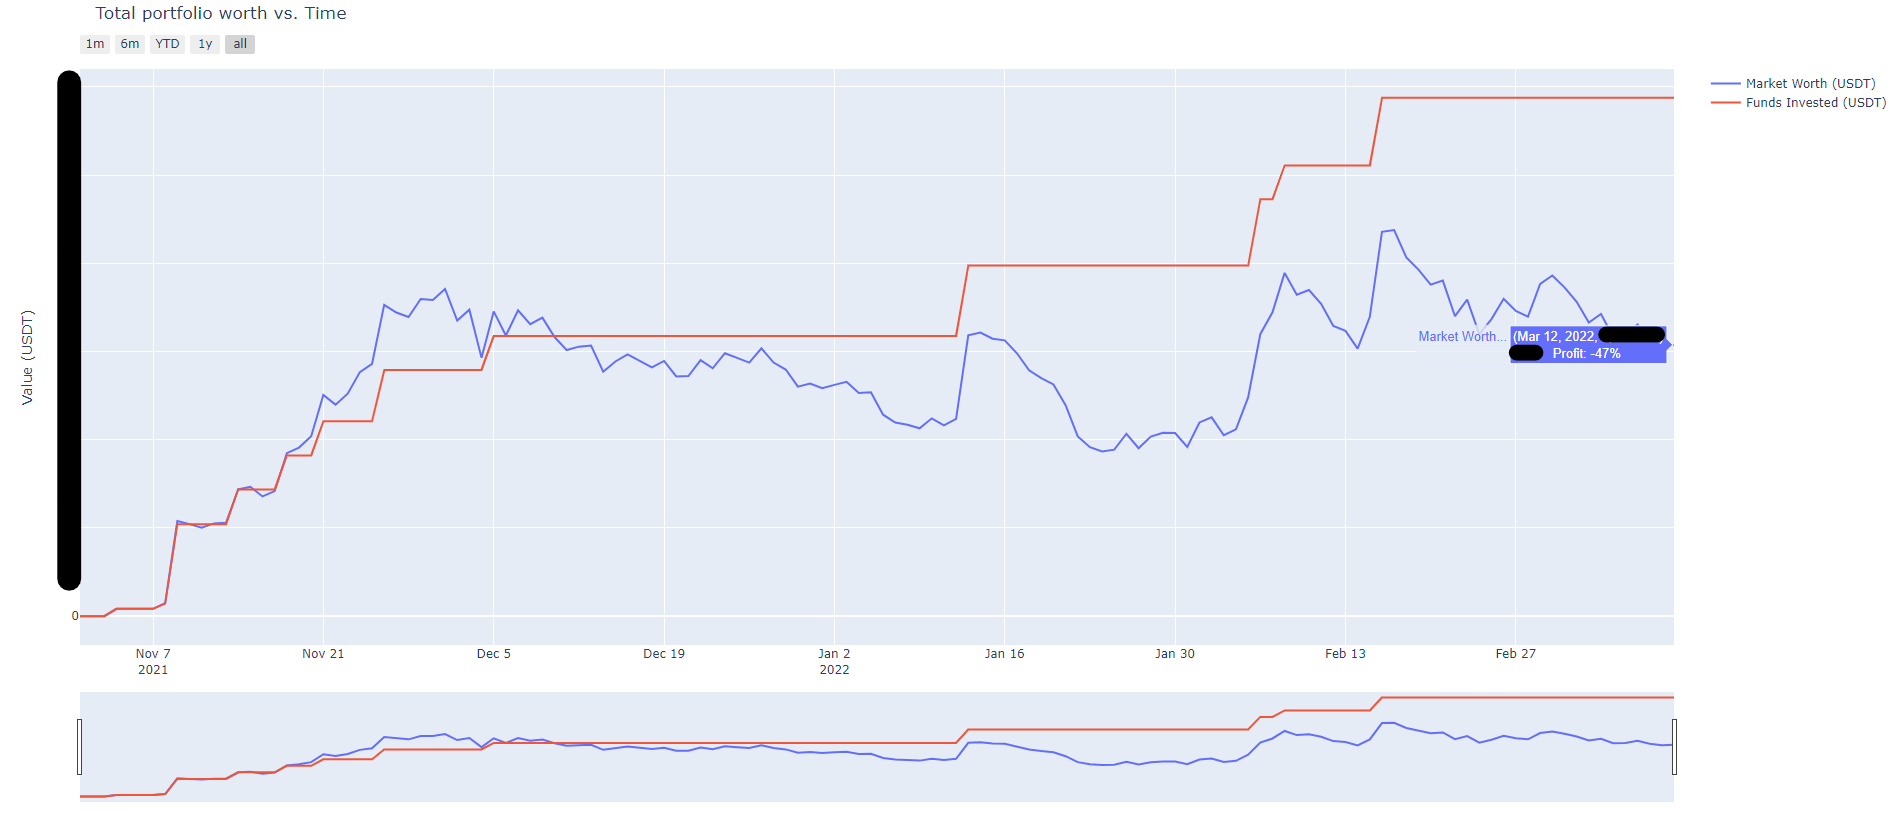

### Per-coin Performance (screenshot of interactive plot with dummy data)
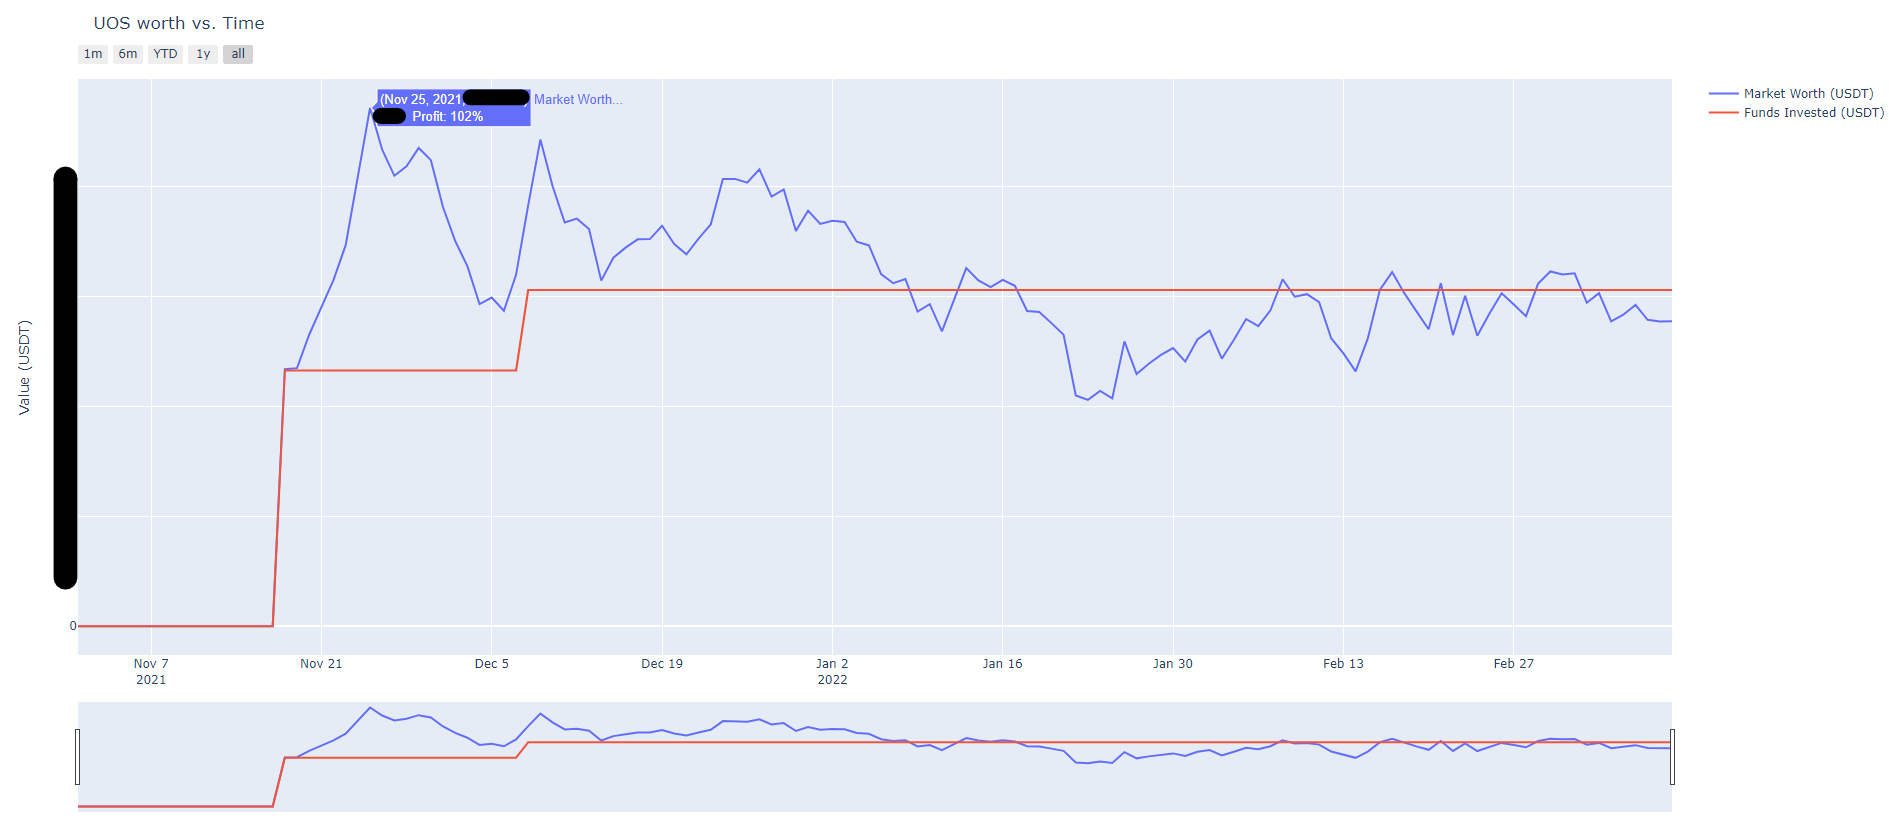

!pip install kucoin-python
!pip install plotly==5.6.0
!pip install tqdm

In [7]:
from datetime import datetime, timedelta
import os
import time
from kucoin.user.user import UserData
from kucoin.trade.trade import TradeData
from kucoin.market.market import MarketData
import plotly.graph_objects as go
from collections import defaultdict
import pickle
import json
from copy import deepcopy
from tqdm import tqdm

#  Credentials
API_KEY = None
API_SECRET = None
API_PASSWORD = None

#  Utilities
START_DATE = datetime.strptime('01.01.2021 00:00:00,00', '%d.%m.%Y %H:%M:%S,%f')  # Enter correct start date
START_DATE_MILLIS = int(START_DATE.timestamp() * 1000)
PAGE_SIZE = 500  # number of entries per page in API response
PLOT_STEP = timedelta(days=1)  # resolution of profit/losses across time

PICKLE_FILEPATH = os.path.join(os.getcwd(), f'total_dict.pickle')  # account data is stored to reduce run time

if all([API_KEY, API_SECRET, API_PASSWORD, START_DATE]):
    print('Precheck completed successfully')
else:
    raise Exception('Enter API, and start date information above')

user = UserData(key=API_KEY, secret=API_SECRET, passphrase=API_PASSWORD)
trade = TradeData(key=API_KEY, secret=API_SECRET, passphrase=API_PASSWORD)
market = MarketData(key=API_KEY, secret=API_SECRET, passphrase=API_PASSWORD)

Precheck completed successfully


In [4]:
def get_account_ledgers():
    '''
    This function will return a list of all transactions made in all of your accounts, beginning from the start date
    until today, in chronological order.
    :return: list
    '''
    ledger_history = []
    tmp_date = START_DATE

    while datetime.today().timestamp() > tmp_date.timestamp():
        tmp_date_millis = int(tmp_date.timestamp() * 1000)
        ledger = user.get_account_ledger(startAt=tmp_date_millis, pageSize=PAGE_SIZE)
        for page in range(1, ledger.get('totalPage') + 1):
            ledger = user.get_account_ledger(startAt=tmp_date_millis, pageSize=PAGE_SIZE, currentPage=page)
            if ledger.get('items'):
                ledger_history.append(ledger)
        tmp_date += timedelta(days=1)

    trans_list = []
    ids = []
    for ledger in ledger_history:
        for page in range(1, ledger.get('totalPage') + 1):
            for item in ledger['items']:
                trans_list.append(item)
                ids.append(item['id'])

    uniqueness_test = len(ids) == len(set(ids))
    print(f'Uniqueness test result is: {uniqueness_test}')
    trans_list.sort(key=lambda x: x.get('createdAt'))

    return trans_list

def get_balances(trans_list: list):
    '''
    This function will read a list of all the transactions made in all accounts, and will output a dictionary of
    currency balances, and a dictionary of funding balances.
    :param trans_list: list of all transactions in all accounts from start date.
    :return: list
    '''
    balance_dict = defaultdict(lambda: [0, 0])  # balances of coins with key being timestamp and value being the dictionary of all the balances
    balance_time_dict = {}
    fund_dict = {}  # dict containing the transactions funding all accounts
    funds_usd = 0

    for item in tqdm(trans_list):
        currency = item.get('currency')
        direction = item.get('direction')
        amount = float(item.get('amount'))
        timestamp = int(item.get('createdAt'))
        biz_type = item.get('bizType')

        if biz_type in ['Deposit', 'Withdraw']:
            balance_dict[currency][0] += (1 if direction == 'in' else -1) * amount
            while True:
                try:
                    deposit_usd = (1 if direction == 'in' else -1) * amount * float(market.get_kline(f'{currency}-USDT',
                                                startAt=int(timestamp / 1000), endAt=int(timestamp / 1000) + 60, kline_type='1min')[0][1])
                    time.sleep(0.2)
                except:
                    print(f'Getting rate limited at the fund dictionary step; sleeping for 5 seconds')
                    time.sleep(5)
                    continue
                funds_usd += deposit_usd
                fund_dict[timestamp] = funds_usd
                break
        elif biz_type == 'Exchange' and currency != 'USDT':
            balance_dict[currency][0] += (1 if direction == 'in' else -1) * amount
        elif biz_type == 'Exchange' and currency == 'USDT':
            balance_dict[currency][0] += (1 if direction == 'in' else -1) * amount
            symbol_pair = json.loads(item.get('context')).get('symbol')
            coin = symbol_pair.replace(currency, '').replace('-', '')
            balance_dict[coin][1] += (-1 if direction == 'in' else 1) * amount  # amount that has been exchanged for the coin

        balance_time_dict[timestamp] = deepcopy(balance_dict)

    return balance_time_dict, fund_dict

def get_balance_values(balance_dict: dict, fund_dict: dict):
    '''
    This function will map currency balances to an arbitrary time. This function will be used to return a daily balance
    and worth of your accounts.
    :param balance_dict: Dictionary of currency balances as outputted by get_balances()
    :param fund_dict: Dictionary of funding balances as outputted by get_balances()
    :return: tuple
    '''
    if not os.path.exists(PICKLE_FILEPATH):
        tmp_date = START_DATE
        total_dict = {}
        total_fund_dict = {}
        total_coin_fund_dict = {}
    else:
        total_dict, total_fund_dict, total_coin_fund_dict = load_pickle()
        tmp_date = list(total_dict.keys())[-1] + PLOT_STEP

    while datetime.today().timestamp() > tmp_date.timestamp():
        tmp_date_secs = int(tmp_date.timestamp())
        tmp_date_millis = int(tmp_date.timestamp() * 1000)
        #  find the day of the last transaction since the current day
        balance_day_diff_list = [(tmp_date_millis - day, day) for day in balance_dict.keys() if (tmp_date_millis - day) > 0]
        fund_diff_list = [(tmp_date_millis - day, day) for day in fund_dict.keys() if (tmp_date_millis - day) > 0]

        if balance_day_diff_list:
            balance_day = min(balance_day_diff_list, key=lambda x: x[0])[1]
            balance = balance_dict[balance_day]

        else:
            balance = {}

        if fund_diff_list:
            fund_day = min(fund_diff_list, key=lambda x: x[0])[1]
            fund = fund_dict[fund_day]
        else:
            fund = 0

        #  extract the price of the coins at the tmp_date using the balance of balance
        price_dict = {}
        coin_fund_dict = {}
        for currency in tqdm(balance.keys()):
            while True:
                try:
                    currency_worth = balance.get(currency, [0, 0])[0] * (float(market.get_kline(f'{currency}-USDT', startAt=tmp_date_secs,
                                                endAt=tmp_date_secs + 60, kline_type='1min')[0][1]) if currency != 'USDT' else 1)
                except Exception as e:
                    msg = e
                    time.sleep(12)
                    print(f'Getting account worth from {tmp_date.strftime("%d_%m_%Y")} Getting rate limited: {msg}')
                    continue
                price_dict[f'{currency}-USDT'] = currency_worth
                funded = balance.get(currency, [0, 0])[1]
                coin_fund_dict[currency] = [currency_worth, funded]
                break

        total_dict[tmp_date] = sum(price_dict.values())
        total_fund_dict[tmp_date] = fund
        total_coin_fund_dict[tmp_date] = coin_fund_dict
        tmp_date += PLOT_STEP

        print(f'Getting account worth from {tmp_date.strftime("%d_%m_%Y")}')

    return total_dict, total_fund_dict, total_coin_fund_dict

def reshape_dict(coin_fund_dict):
    '''
    This function reshapes the inputted dictionary to be structured as {currency: [market_worth_dict, funded_dict]} for
    easy plotting.
    :param coin_fund_dict: input dictionary from get_balance_values()
    :return: dict
    '''
    ret_dict = {}
    for currency in coin_fund_dict[list(coin_fund_dict.keys())[-1]].keys():
        total_dict = dict([(key, val) for key, val in zip(list(coin_fund_dict.keys()), [coin_fund_dict.get(timestamp).get(currency, [0, 0])[0]
                                                                                        for timestamp in coin_fund_dict.keys()])])
        fund_dict = dict([(key, val) for key, val in zip(list(coin_fund_dict.keys()), [coin_fund_dict.get(timestamp).get(currency, [0, 0])[1]
                                                                                       for timestamp in coin_fund_dict.keys()])])

        ret_dict[currency] = [total_dict, fund_dict]

    return ret_dict

def plot(total_dict, total_fund_dict, title):
    # Create figure
    fig = go.Figure()

    total_y = list(total_dict.values())
    fund_y = list(total_fund_dict.values())
    profit = [int((100 * (total - fund) / fund) if fund else 0) for fund, total in zip(fund_y, total_y)]
    hovertext = [f'{int(total)} \n Profit: {percent}%' for total, percent in zip(total_y, profit)]

    fig.add_trace(
        go.Scatter(x=list(total_dict.keys()), y=total_y, name='Market Worth (USDT)', hovertext=hovertext))

    fig.add_trace(
        go.Scatter(x=list(total_fund_dict.keys()), y=fund_y, name='Funds Invested (USDT)'))

    # Set title
    fig.update_layout(title_text=title)

    # Y-axis title
    fig.update_yaxes(title_text='Value (USDT)')

    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show()

def save_pickle(input_object):
    try:
        with open(PICKLE_FILEPATH, 'wb') as f:
            pickle.dump(input_object, f)
    except Exception as e:
        print(f'Failed to save pickle file \n {e}')

def load_pickle():
    try:
        with open(PICKLE_FILEPATH, 'rb') as f:
            loaded_obj = pickle.load(f)
        return loaded_obj
    except:
        print(f'No pickle file found at path {PICKLE_FILEPATH}')

In [ ]:
trans_list = get_account_ledgers()
balance_dict, fund_dict = get_balances(trans_list)
worth_dict, total_fund_dict, coin_fund_dict = get_balance_values(balance_dict, fund_dict)
save_pickle([worth_dict, total_fund_dict, coin_fund_dict])
plot_dict = reshape_dict(coin_fund_dict)

plot(worth_dict, total_fund_dict, title='Total portfolio worth vs. Time')
for coin, (total, fund) in plot_dict.items():
    title = f'{coin} worth vs. Time'
    plot(total, fund, title=title)